In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import matplotlib.pyplot as plt
import re
import pandas as pd
import scipy.optimize as opt

In [2]:
year = '2018'
start_day = int(str(year) + '0101')
end_day = int(str(year) + '1231')

In [4]:
# #爬蟲取得加權指數資料
# start_date = '2018-01-01'
# end_date = '2021-12-31'

# resp = requests.get(f'https://api.finmindtrade.com/api/v3/data?dataset=TaiwanStockPrice&date={start_date}&end_date={end_date}&stock_id=TAIEX')
# TAIEX_data = resp.json()['data']
# TAIEX_data = pd.DataFrame(TAIEX_data)
# TAIEX_data['daily_return'] = TAIEX_data.close / TAIEX_data.close.shift(1) - 1

# TAIEX_data

In [3]:
#讀取上市普通股股價與加權指數資料
data = pd.read_csv('data.csv', encoding='utf-16', sep='\t')
data['證券代碼'] = data['證券代碼'].str.split(' ').str[0]
#data

In [4]:
#計算該年度各產業在市場的比重
def get_industrys_weight(data, year):
    start_date = year + '0101'
    end_date = year + '1231'
    filtered_data = data[(data['年月日'] >= int(start_date)) & (data['年月日'] <= int(end_date))]
    industrys_marketValue = filtered_data.groupby('TSE新產業名').sum()['市值(百萬元)']
    industrys_weight = industrys_marketValue / industrys_marketValue.sum()
    return industrys_weight

In [5]:
#定義選取股票的函數

def get_n_stocks(data, date, n):
    year = str(date)[:4]
    industrys_weight = get_industrys_weight(data, year)
    #算出各產業要選幾隻股票
    n_stocks = (industrys_weight * n)
    n_stocks = n_stocks.astype(int)

    #找出所有產業類型
    if year == '2022':
        filter_data = data[data['年月日'] == int(date)]
    elif year == '2021':
        filter_data = data[data['年月日'] == int(date)]
    else:
        filter_data = data[data['年月日'] == int(date)]
    industrys = filter_data['TSE新產業名'].unique()
    #移除nan產業
    industrys = industrys[~pd.isna(industrys)]
    

    #紀錄不足的股票產業
    insufficient_industrys = []
    for industry in industrys:
        if n_stocks[industry] > len(filter_data[filter_data['TSE新產業名'] == industry]['證券代碼'].unique()):
            print(industry, f'產業股票數量不足需求{n_stocks[industry]}隻，只有{len(filter_data[filter_data["TSE新產業名"] == industry]["證券代碼"].unique())}隻')
            n_stocks[industry] = len(filter_data[filter_data['TSE新產業名'] == industry]['證券代碼'].unique())
            insufficient_industrys.append(industry)
    print('不足的產業有', insufficient_industrys)


    while n_stocks.sum() != n:
        #從充足的產業中隨機挑一個，增加一隻股票
        industry = random.choice(list(set(industrys) - set(insufficient_industrys)))
        #如果該產業股票數量已經達到上限，則跳過
        if n_stocks[industry] == len(filter_data[filter_data['TSE新產業名'] == industry]['證券代碼'].unique()):
            continue
        n_stocks[industry] += 1
            

    #從上面算出的產業股票數量中，從該產業市值最大的股票開始選
    selected_stocks = []
    for industry in n_stocks.index:
        filtered_data = data[data['TSE新產業名'] == industry]
        if year == '2022':
            filtered_data = filtered_data[filtered_data['年月日'] == int(year + '0103')]
        elif year == '2021':
            filtered_data = filtered_data[filtered_data['年月日'] == int(year + '0104')]
        else:
            filtered_data = filtered_data[filtered_data['年月日'] == int(year + '0102')]
        filtered_data = filtered_data.sort_values(by='市值(百萬元)', ascending=False)
        selected_stocks += list(filtered_data['證券代碼'].head(n_stocks[industry]))
    print('選出的股票數量為', len(selected_stocks))

    return selected_stocks

def get_n_stocks_by_value(data, year, n):
    if year == '2022':
        filter_data = data[(data['年月日'] == int(year + '0103')) & (data['證券代碼'] != 'Y9999') & (data['證券代碼'] != 'Y9997')]
    elif year == '2021':
        filter_data = data[(data['年月日'] == int(year + '0104')) & (data['證券代碼'] != 'Y9999') & (data['證券代碼'] != 'Y9997')]
    else:
        filter_data = data[(data['年月日'] == int(year + '0102')) & (data['證券代碼'] != 'Y9999') & (data['證券代碼'] != 'Y9997')]

    filter_data = filter_data.sort_values(by='市值(百萬元)', ascending=False)
    selected_stocks = filter_data['證券代碼'].head(n)
    print('選出的股票數量為', len(selected_stocks))
    return selected_stocks

def get_n_stocks_by_dateAndValue(data, date, n):
    filter_data = data[(data['年月日'] == int(date)) & (data['證券代碼'] != 'Y9999') & (data['證券代碼'] != 'Y9997')]
    filter_data = filter_data.sort_values(by='市值(百萬元)', ascending=False)
    selected_stocks = filter_data['證券代碼'].head(n)
    return selected_stocks

In [6]:
#算權重
def get_weight(daily_data):
    stock_and_weight = {}
    total_value = daily_data['市值(百萬元)'].sum()
    for i in range(len(daily_data)):
        stock_and_weight[daily_data['證券代碼'][i]] = daily_data['市值(百萬元)'][i]/total_value
    return stock_and_weight

# # 使用範例
# get_weight(data_of_the_date[20190102])

In [7]:
import datetime

def get_month(date_intstring):
    date = datetime.datetime.strptime(str(date_intstring).split('\n')[0].strip(), '%Y%m%d')
    return date.month

def convert_to_minguo_date(date_str):
    date_obj = datetime.datetime.strptime(str(date_str), '%Y%m%d')
    minguo_year = date_obj.year - 1911
    minguo_date_str = date_obj.strftime(f"{minguo_year}%m%d")
    return minguo_date_str

def convert_format_to_float(s):
    s_without_commas = s.replace(',', '')
    s_as_integer = float(s_without_commas)
    return s_as_integer


In [8]:
def get_stockDailyReturn_by_date(stock, date, stock_price):
    result_df = stock_price[stock_price['年月日'] == int((date))]
    try:
        daily_return = (float(result_df['報酬率％'])) / 100
    except Exception as e:
        print(f'股票:{stock} 在{date}計算日報酬時出現錯誤：' + str(e))
        daily_return = 0
    return daily_return * 100

# #使用範例
# get_stockDailyReturn_by_date(2330, 20200106, stock_price_dict['2330'])
    

In [9]:
def get_stock_prices(data, stock_list, year):
    last_year = str(int(year) - 1)
    result_dict = {}
    start_date = last_year + '0101'
    end_date = str(year) + '1231'
    for stock in stock_list:
        result = data[(data['證券代碼'] == stock) & (data['年月日'] >= int(start_date)) & (data['年月日'] <= int(end_date))]
        result_dict[stock] = result
    return result_dict
    

In [10]:
def get_first_day_of_month_data(data_of_the_date, month):
    if month < 10:
        month = '0' + str(month)
    else:
        month = str(month)
    return next((value for key, value in data_of_the_date.items() if str(key).startswith(str(year + str(month)))), None)

In [11]:
def tracking(start_date, end_date, data_of_the_date, data, n):
    year = int(str(start_date)[:4])
    weights = {}
    stock_price_dict = {}
    stock_list = {}
    for month in range(1, 13):
        first_day_of_month_data = get_first_day_of_month_data(data_of_the_date, month)
        stock_list[month] = get_n_stocks_by_dateAndValue(data, first_day_of_month_data['年月日'][0], n) #可以選擇用市值或是產業+市值
        filt_first_day_of_month_data = first_day_of_month_data[first_day_of_month_data['證券代碼'].isin(stock_list[month])].reset_index(drop=True)
        weights[month] = get_weight(filt_first_day_of_month_data)
        stock_price_dict[month] = get_stock_prices(data, weights[month], year)

    
    day_list = list(data['年月日'])
    day_set = sorted(set(day_list))
    portfolio_daily_return = []
    change = True
    temp_weight_combination = {}
    for idx, day in enumerate(day_set):
        if int(day) < int(start_date) or int(day) > int(end_date):
            continue
        if day not in data_of_the_date:
            continue

        #判斷該日該採用哪個調整參考月的權重
        month = get_month(day)
        last_month = month - 1
        weight_combination = weights[month]
        stocks = stock_list[month]
        if last_month in [i for i in range(1,13)] and get_month(int(day_set[idx-1])) != get_month(int(day)):
            change = True

        if change == True:
            daily_return = 0
            for stock in stocks:
                daily_return += get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[month][str(stock)]) * weight_combination[stock]
            portfolio_daily_return.append(daily_return)
            temp_weight_combination = weight_combination
            print(f'權重發生變更：')
            change = False
        else:
            daily_return = 0
            new_weight = {}
            total_weight = 0
            for stock in stocks:
                total_weight += ((get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[month][str(stock)])/100 + 1) * temp_weight_combination[stock])
            for stock in stocks:
                new_weight[stock] = ((get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[month][str(stock)])/100 + 1) * temp_weight_combination[stock]) / total_weight
            for stock in stocks:
                daily_return += get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[month][str(stock)]) * temp_weight_combination[stock]
            temp_weight_combination = new_weight
            portfolio_daily_return.append(daily_return)  
        print(f'day: {day} ， {temp_weight_combination}')   

    return portfolio_daily_return
    

In [12]:
def get_stock_price_dict(stock_list, year):
    stock_price_dict = {}
    for stock in stock_list:
        start_day = year + '0101'
        stock_price_dict[str(stock)] = data[ (data['證券代碼'] == stock) & (data['年月日'] >= int(start_day)) & (data['年月日'] <= int(end_day))].reset_index(drop=True)
        stock_price_dict[str(stock)] = stock_price_dict[str(stock)].reset_index(drop=True)
    return stock_price_dict

In [15]:
#將dataframe依照年月日切割，存入dict, ex. data_of_the_date[20190102]可取出當天的資料
def get_data_of_the_date(data, year):
    data_of_the_date = {}
    filtered_data = data[ (data['年月日'] >= int(str(year) + '0101')) & (data['年月日'] <= int(str(year) + '1231'))].reset_index(drop=True)
    for i in range(0, len(filtered_data)):
        if filtered_data['年月日'][i] not in data_of_the_date:
            data_of_the_date[filtered_data['年月日'][i]] = filtered_data.iloc[i:i+1]
        else:
            data_of_the_date[filtered_data['年月日'][i]] = pd.concat([data_of_the_date[filtered_data['年月日'][i]], filtered_data.iloc[i:i+1]])

    for i in data_of_the_date:
        data_of_the_date[i] = data_of_the_date[i].reset_index(drop=True)
    return data_of_the_date

In [16]:
data_of_the_date = get_data_of_the_date(data, year)

# tracking_return_400 = tracking(start_day, end_day, data_of_the_date, data, 400)
tracking_return_300 = tracking(start_day, end_day, data_of_the_date, data, 350)
# tracking_return_250 = tracking(start_day, end_day, data_of_the_date, data, 250)

權重發生變更：
day: 20180102 ， {'1101': 0.005325352447037689, '1102': 0.003252393927926838, '1103': 0.00035751903883236613, '1104': 0.0005157949818394396, '1201': 0.00036547915562786605, '1210': 0.0008501885089469483, '1215': 0.0005948814870705916, '1216': 0.013100945500614318, '1218': 0.0002924656705381084, '1225': 0.0005042322259770108, '1227': 0.0023328288838053175, '1229': 0.001192919572180778, '1232': 0.0004950712294925347, '1234': 0.0004329342833000764, '1301': 0.021426404208349056, '1303': 0.0209527086373203, '1304': 0.000659763301123567, '1305': 0.0005562131610855554, '1307': 0.0004633680057035609, '1308': 0.0003430741717163944, '1310': 0.0004102205017542965, '1312': 0.0009580618158652745, '1313': 0.0007778612408223199, '1314': 0.0014265421379590487, '1319': 0.001179057989485166, '1326': 0.020814058499515925, '1338': 0.0003322319436673514, '1402': 0.004922131358327711, '1409': 0.0005580659468914045, '1419': 0.0004524228451097486, '1434': 0.0018091767177151473, '1440': 0.00078448323453

In [17]:
def get_assets_growth(daily_return):
    assets_growth = []
    for i in range(len(daily_return)):
        if i == 0:
            assets_growth.append(100)
        else:
            assets_growth.append(assets_growth[i-1] * (1 + daily_return[i]/100))
    return assets_growth

In [18]:
#取出該期間TAIEX的日報酬
TAIEX_daily_return = []
TAIEX_data = data[(data['證券代碼'] == 'Y9999') & (data['年月日'] >= int(start_day)) & (data['年月日'] <= int(end_day))]
TAIEX_data.reset_index(drop=True, inplace=True)
for i in range(len(TAIEX_data)):
    TAIEX_daily_return.append(TAIEX_data['報酬率％'][i])

#畫出台50指成長曲線

print(f'加權指數報酬：{(get_assets_growth(TAIEX_daily_return)[-1]/get_assets_growth(TAIEX_daily_return)[0] - 1)*100}%')
print(f'追蹤400報酬：{(get_assets_growth(tracking_return_400)[-1]/get_assets_growth(tracking_return_400)[0] - 1)*100}%')
print(f'追蹤300報酬：{(get_assets_growth(tracking_return_300)[-1]/get_assets_growth(tracking_return_300)[0] - 1)*100}%')
print(f'追蹤250報酬：{(get_assets_growth(tracking_return_250)[-1]/get_assets_growth(tracking_return_250)[0] - 1)*100}%')

plt.plot(get_assets_growth(TAIEX_daily_return), label='TAIEX')
plt.plot(get_assets_growth(tracking_return_400), label='Tracking_400')
plt.plot(get_assets_growth(tracking_return_300), label='Tracking_300')
plt.plot(get_assets_growth(tracking_return_250), label='Tracking_250')




plt.legend()

加權指數報酬：-9.18083346628229%


NameError: name 'tracking_return_400' is not defined

In [19]:
def get_tracking_error(tracking_return, index50_daily_return):
    dif = []
    for i in range(len(tracking_return)):
        dif.append(tracking_return[i] - index50_daily_return[i])
    return np.array(dif).std() * np.sqrt(252)

In [20]:
print(f'400 stocks tracking error: {get_tracking_error(tracking_return_400, TAIEX_daily_return).round(3)}%')
print(f'300 stocks tracking error: {get_tracking_error(tracking_return_300, TAIEX_daily_return).round(3)}%')
print(f'250 stocks tracking error: {get_tracking_error(tracking_return_250, TAIEX_daily_return).round(3)}%')

NameError: name 'tracking_return_400' is not defined

In [21]:
import pandas as pd


df = pd.DataFrame()

day_list = list(TAIEX_data['年月日'])
day_set = sorted(set(day_list))
#轉乘str
day_set = [str(day) for day in day_set if int(day) >= start_day and int(day) <= end_day]


df['日期'] = pd.to_datetime(day_set).strftime('%Y%m%d')
df['TAIEX日報酬%'] = TAIEX_daily_return
# df['400追蹤日報酬%'] = tracking_return_400
df['300追蹤日報酬%'] = tracking_return_300
# df['250追蹤日報酬%'] = tracking_return_250



df.to_csv(f'{str(start_day)[:4]}top_tracking_difference.csv', encoding='utf-16', sep='\t', index=False)

============================================================================================================================

In [3]:
total_data = pd.read_excel('純市值選股(每月初調整).xlsx')
top_total_data = pd.read_excel('產業加市值選股(每月初調整).xlsx')

In [4]:
def calculate_tracking_difference(portfolio_returns, index_returns, n):
    # 將百分比轉換為小數
    portfolio_returns = [return_percent / 100 for return_percent in portfolio_returns]
    index_returns = [return_percent / 100 for return_percent in index_returns]

    # 計算 ETF 的年化收益率
    etf_total_return = sum(portfolio_returns)
    etf_daily_return = etf_total_return / len(portfolio_returns)
    etf_annual_return = ((1 + etf_daily_return) ** 252) - 1

    # 計算指數的年化收益率
    index_total_return = sum(index_returns)
    index_daily_return = index_total_return / len(index_returns)
    index_annual_return = ((1 + index_daily_return) ** 252) - 1

    # 計算年度跟踪差異
    tracking_difference = etf_annual_return - index_annual_return

    print(f"{n} stocks tracking difference: {round(tracking_difference*100, 3)}%")

def show_info(data):
    TAIEX_daily_return = data['TAIEX日報酬%']
    tracking_return_400 = data['400追蹤日報酬%']
    tracking_return_300 = data['300追蹤日報酬%']
    tracking_return_250 = data['250追蹤日報酬%']
    print(f'加權指數報酬：{round((get_assets_growth(TAIEX_daily_return)[-1]/get_assets_growth(TAIEX_daily_return)[0] - 1)*100, 3)}%')
    print(f'追蹤400報酬：{round((get_assets_growth(tracking_return_400)[-1]/get_assets_growth(tracking_return_400)[0] - 1)*100, 3)}%')
    print(f'追蹤300報酬：{round((get_assets_growth(tracking_return_300)[-1]/get_assets_growth(tracking_return_300)[0] - 1)*100, 3)}%')
    print(f'追蹤250報酬：{round((get_assets_growth(tracking_return_250)[-1]/get_assets_growth(tracking_return_250)[0] - 1)*100, 3)}%')

    print('*******************************')

    print(f'400 stocks tracking error: {get_tracking_error(tracking_return_400, TAIEX_daily_return).round(3)}%')
    print(f'300 stocks tracking error: {get_tracking_error(tracking_return_300, TAIEX_daily_return).round(3)}%')
    print(f'250 stocks tracking error: {get_tracking_error(tracking_return_250, TAIEX_daily_return).round(3)}%')

    print('*******************************')

    calculate_tracking_difference(tracking_return_400, TAIEX_daily_return, 400)
    calculate_tracking_difference(tracking_return_300, TAIEX_daily_return, 300)
    calculate_tracking_difference(tracking_return_250, TAIEX_daily_return, 250)

    print('*******************************')

    plt.plot(get_assets_growth(TAIEX_daily_return), label='TAIEX')
    plt.plot(get_assets_growth(tracking_return_400), label='Tracking_400')
    plt.plot(get_assets_growth(tracking_return_300), label='Tracking_300')
    plt.plot(get_assets_growth(tracking_return_250), label='Tracking_250')
    plt.legend()

產業+市值選股
加權指數報酬：37.548%
追蹤400報酬：56.64%
追蹤300報酬：57.049%
追蹤250報酬：56.947%
*******************************
400 stocks tracking error: 1.021%
300 stocks tracking error: 1.184%
250 stocks tracking error: 1.324%
*******************************
400 stocks tracking difference: 5.218%
300 stocks tracking difference: 5.337%
250 stocks tracking difference: 5.325%
*******************************


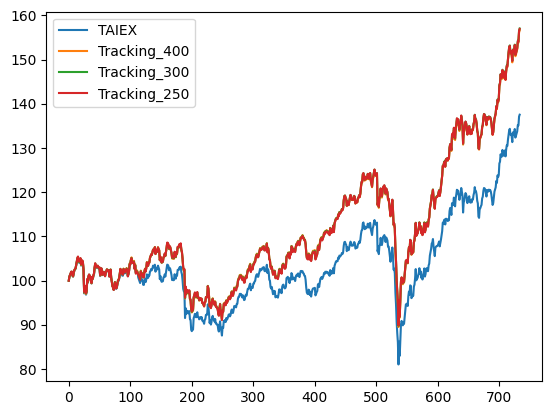

In [8]:
print('產業+市值選股')
show_info(total_data)

純市值選股
加權指數報酬：37.548%
追蹤400報酬：57.971%
追蹤300報酬：58.792%
追蹤250報酬：59.946%
*******************************
400 stocks tracking error: 1.129%
300 stocks tracking error: 1.377%
250 stocks tracking error: 1.606%
*******************************
400 stocks tracking difference: 5.575%
300 stocks tracking difference: 5.805%
250 stocks tracking difference: 6.121%
*******************************


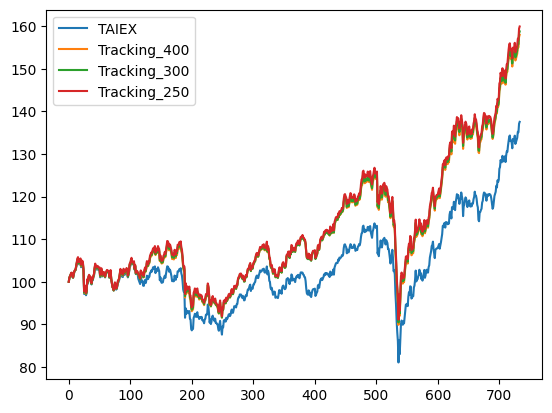

In [9]:
print('純市值選股')
show_info(top_total_data)